# Strategic users in EIP 1559

###### August 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

In our previous notebook, we simulated users interacting with the EIP 1559 transaction fee market mechanism for inclusion. Our users were strategic to some extent: they observed the prevailing basefee, evaluated their values and costs and decided whether to send a transaction or not. We saw that once the system reaches stationarity, users who aren't deterred by the basefee can expect next-block inclusion.

We made one big assumption there, which is that users respect the commonly stated heuristic of setting their premiums (in general, what the miner receives from the transaction) at a fixed value compensating the miner for the extra work of including one extra transaction. In this notebook, we relax this assumption and look at what happens when users bid strategically, trying to outcompete each other in transitionary periods, before the basefee settles.

## Starting up

You can simply run the following commands in a terminal, assuming `pipenv` is installed on your machine.

```
git clone https://github.com/barnabemonnot/abm1559.git
cd abm1559
pipenv install
pipenv shell
jupyter lab
```

We first load up a few classes from our [`abm1559`](https://github.com/barnabemonnot/abm1559) library.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

import pandas as pd

## Introducing strategic users

Our previous simulation only featured one type of users, `User1559`. Users received some random value (in Gwei, per gas unit) for transaction inclusion and costs (in Gwei, per gas and time unit) for waiting.

For instance, Alice has 15 Gwei/gas value for inclusion, and cost 0.5 Gwei/gas/block. If Alice waits for 5 blocks to be included, her payoff for each gas unit she obtains is 15 - 5 * 0.5 = 12.5. To this, we subtract the fee Alice must pay for inclusion, or _gas price_. Assuming the basefee currently sits at 10 Gwei/gas and Alice set her premium at 1 Gwei/gas, her total gas price is 11 Gwei/gas. Her final payoff is then 12.5 - 11 = 1.5 Gwei/gas. In other words:

$$ \texttt{payoff} = \texttt{value} - \texttt{cost from waiting} - \texttt{transaction fee} $$

Users estimate their final payoff by estimating how long they will wait for inclusion. Our default `User1559` estimates a fixed waiting time of 5 blocks. Let's go ahead and change that to 1 block, as we have done with the `OptimisticUser` in the previous notebook.

In [2]:
class OptimisticUser(User1559):
    def expected_time(self, params):
        return 1

`OptimisticUser`s expect a small waiting time, but still set their premium to a fixed value. Can a strategic user do better? Let's find out!

We'll subclass our `User1559` again to define the strategic user.

In [3]:
class StrategicUser(User1559):
    """
    A strategic affine user sending 1559 transactions.
    """
    # Expects to be included in the next block
    # Prefers not to participate if its expected payoff is negative
    # Strategic gas_premium

    def expected_time(self, params):
        return 1

    def decide_parameters(self, params):
        if params["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = params["min_premium"]

        gas_premium = min_premium + 0.1 * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block
        }

    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

As our `OptimisticUser` does, `StrategicUser` expects next-block inclusion. We also change `decide_parameters`: the strategic user sets its premium to _the minimum premium seen in the previous block_, plus 0.1 Gwei. Strategic users are trying to outbid the cheapest user (from the miner's point of view) who was included in the previous block.

Users attach premiums to their transactions as well as fee caps. The fee cap is an instruction to not charge a gas price greater than the cap, whatever happens with the basefee, and protects users from accidental overbidding. Miners receive either the whole premium or the slack between current basefee and feecap, whichever is lower. We call this the _tip_.

$$ \texttt{tip} = \min(\texttt{fee cap} - \texttt{basefee}, \texttt{gas premium}) $$

We set the fee cap of strategic users like we set it for non-strategic ones: since users receive at most their value from getting included, they set their cap to their value.

## Mixed simulations

We'll now pit `OptimisticUser`s against `StrategicUser`s. We modify the `simulate` function we used previously to specify at each simulation step how much of each type we expect to spawn. These are the simulation steps:

1. We sample from a Poisson distribution to obtain the number of new users spawning between two blocks.
2. We spawn optimistic and strategic users according to the shares specified by `shares_scenario`.
3. Each user decides whether to transact or not (`decide_transactions`).
4. Transactions are added to the transaction pool.
5. The miner decides on a set of transactions to include, ranking transactions according to their tips, with higher tips at the top of the list.
6. A block is created and added to the chain.
7. Basefee is updated.
8. Repeat.

In [4]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
            "min_premium": min_premium,
        }
        
        # We return some demand which on expectation yields 2000 new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # Record the min premium in the block
        min_premium = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "strategic": len([user for user in users if type(user) is StrategicUser]),
            "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
            "pool_strat_users": len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == StrategicUser]),
            "pool_nonstrat_users": len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == OptimisticUser]),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

We'll start with a simulation for 200 blocks. We set equal shares of strategic and non-strategic users, with on average a total of 2500 users spawning each round. Remember that our blocks can accommodate at most 952 users, but target inclusion of about half of this number, i.e., 475 of them. There is plenty of space then for strategic users (on average 1500 of them each round) to grab all the available space.

In [5]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

strategic_share = 0.5
shares_scenario = [{
    StrategicUser: strategic_share,
    OptimisticUser: 1 - strategic_share,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

What does `df` reveal?

In [6]:
df

,block,basefee,users,strategic,nonstategic,decided_txs,included_txs,blk_min_premium,blk_avg_gas_price,blk_avg_tip,pool_length,pool_strat_users,pool_nonstrat_users
0,0,1.000000,2434,1217,1217,2118,952,1.1,2.100000,1.100000,1166,107,1059
1,1,1.124900,2411,1205,1206,2043,952,1.2,2.324900,1.200000,2257,174,2083
2,2,1.265400,2588,1294,1294,2186,952,1.3,2.565400,1.300000,3491,313,3178
3,3,1.423448,2493,1246,1247,2111,952,1.4,2.823448,1.400000,4650,402,4248
4,4,1.601237,2454,1227,1227,2055,952,1.5,3.101237,1.500000,5753,462,5291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,14.731966,2415,1207,1208,438,438,1.0,15.784934,1.052968,10658,72,10586
96,96,14.584278,2442,1221,1221,473,473,1.0,15.633326,1.049049,10658,72,10586
97,97,14.572063,2483,1241,1242,474,474,1.0,15.621009,1.048945,10658,72,10586
98,98,14.563684,2412,1206,1206,492,492,1.0,15.607790,1.044106,10658,72,10586


We see on average 2500 `users`, with half of them `strategic` and the other half `non-strategic`. Many decide to transact in the first few rounds, more than are eventually included (`decided_txs` > `included_txs`). The pool length, how many decided transactions were not included yet, increases steadily, but all users in the pool are non-strategic! We have the first clue that being strategic is not a bad idea, but we'll try to interpret more precisely what is happening exactly.

### Strategic users enter a bidding war

Let's look at the basefee and the minimum premium in a block.

<AxesSubplot:xlabel='block'>

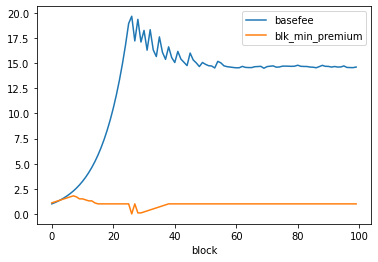

In [7]:
df.plot("block", ["basefee", "blk_min_premium"])

In [8]:
df[(df.block >= 24) & (df.block <= 27)]

,block,basefee,users,strategic,nonstategic,decided_txs,included_txs,blk_min_premium,blk_avg_gas_price,blk_avg_tip,pool_length,pool_strat_users,pool_nonstrat_users
24,24,16.855204,2464,1232,1232,179,952,1.0,17.864867,1.009664,15142,72,15070
25,25,18.960418,2474,1237,1237,0,621,1.0,19.485227,0.524809,14521,72,14449
26,26,19.681151,2508,1254,1254,0,0,0.0,0.000000,0.000000,14521,72,14449
27,27,17.221007,2517,1258,1259,211,952,1.0,18.066893,0.845886,13780,192,13588


Basefee increases until reaching its apex at block 26. This is the same behaviour we observed in the previous notebook: too many users want in so the basefee quickly reaches a high value, where no one is willing to pay this much. After the apex, the basefee climbs down, accommodating some of the most high-valued new users as well as equally high-valued users in the pool who were priced out.

We also plot (in orange) the minimum premium observed in the block. The dynamics are curious: to understand them, remember that strategic users systematically bid just above the minimum premium observed in the previous block. During the transitionary period between blocks 0 and 26, too many users want in so the basefee increases. At the same time, the minimum premium observed in a block increases too. We can imagine that enough strategic users successfully outbid non-strategic ones to fill the whole block. Since strategic users always bid above the smallest premium in the previous block, they bid a premium of 1.1 Gwei the first time, then 1.2, then 1.3 etc.

As the basefee increases, fewer and fewer new strategic users decide to transact, as low-valued users are priced out, leaving some space for non-strategic users to be included. This releases some pressure on the premiums, until block 26 where basefee is so high that no one is included (and the minimum premium is zero).

<AxesSubplot:xlabel='block'>

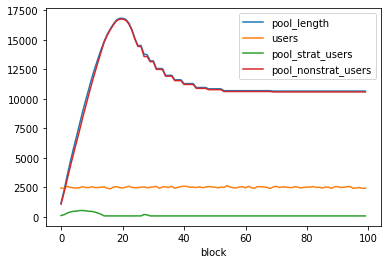

In [9]:
df.plot("block", ["pool_length", "users", "pool_strat_users", "pool_nonstrat_users"])

We observe in the chart above the transaction pool length, and indeed confirm that most users in the pool are non-strategic. **Strategic users get ahead by outbidding them**.

### When basefee settles, strategic behaviour does not help

We'll now look at the trace more closely. We export simulation data to pandas `DataFrame`s for ease of manipulation, using the `export` methods we defined in our classes.

In [10]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

# Compute included users' costs
user_txs_df["cost"] = user_txs_df.apply(
    lambda row: row.user.cost({
        "current_block": row.block_height,
        "gas_price": row.tx.gas_price({
            "basefee": row.basefee * (10 ** 9) # we need basefee in wei
        })
    }) / (10 ** 9), # put payoff is in Gwei
    axis = 1
)

# Compute included users' payoffs
user_txs_df["payoff"] = user_txs_df.apply(
    lambda row: row.user.payoff({
        "current_block": row.block_height,
        "gas_price": row.tx.gas_price({
            "basefee": row.basefee * (10 ** 9) # we need basefee in wei
        })
    }) / (10 ** 9), # put payoff is in Gwei
    axis = 1
)

We'll obtain a few descriptive statistics, comparing for instance for each block the average value of included strategic users vs. non-strategic users.

In [11]:
# Obtain per user type statistics
txs_per_group = user_txs_df[["block_height", "user_type", "value", "tip", "payoff", "cost"]].groupby(
    ["block_height", "user_type"]
).agg({
    "user_type": ["count"], "value": ["mean"], "tip": ["min"], "payoff": ["mean"], "cost": ["mean"]
}).unstack(level=-1).reset_index().fillna(0)

# Reformat them in wide format
txs_per_group.columns = ['block_height', 'strategic', 'nonstrategic',
                         'strat_value_mean', 'nonstrat_value_mean',
                         'strat_tip_min', 'nonstrat_tip_min',
                         'strat_payoff_mean', 'nonstrat_payoff_mean',
                         'strat_cost_mean', 'nonstrat_cost_mean']
txs_per_group["total"] = txs_per_group.apply(
    lambda row: row.strategic + row.nonstrategic,
    axis = 1
)
txs_per_group["percent_strategic"] = txs_per_group.apply(
    lambda row: row.strategic / row.total * 100,
    axis = 1
)

We first check how many users in each block are strategic/non-strategic.

<AxesSubplot:xlabel='block_height'>

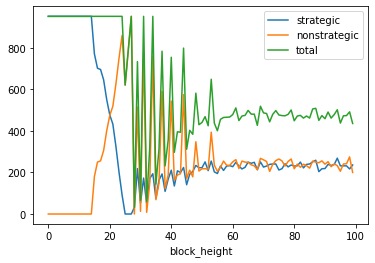

In [12]:
txs_per_group.plot("block_height", ["strategic", "nonstrategic", "total"])

From this plot, a few observations stand out:
    
1. For the first few blocks, only strategic users are included.
2. This changes before the basefee reaches its apex (at block 26), as more and more non-strategic users are included. By block 20, more non-strategic users are included than strategic.
3. There are weird sawtooths between blocks 25 and 50. I don't believe these have much interpretation, having more to do with discontinuous behaviour of the simulation.
4. Once series stabilise, we observe that strategic and non-strategic users get in at equal ratio. Remember that we spawn equal numbers of strategic and non-strategic users each round, so we may conclude here that strategic users lost their overbidding advantage: at this point, the basefee is more determinant to decide who gets in or not.

This is confirmed by the following plot, which shows the percentage of strategic users in each block.

<AxesSubplot:xlabel='block_height'>

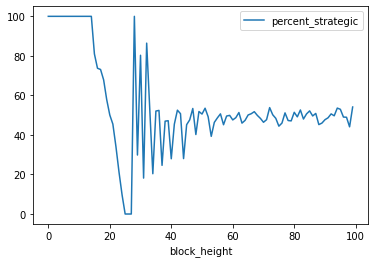

In [13]:
txs_per_group.plot("block_height", "percent_strategic")

### The full story

In the chart above, between blocks 0 and 26, before basefee reaches its apex, strategic users are included in much higher proportions than non-strategic users. Not surprising, since they post higher premiums. More surprising however is that this proportion is decreasing, until it is reversed: by block 20, more non-strategic users are included than strategic.

This is trickier to explain but we can sketch the following narrative.

1. Most users, both strategic and non-strategic, have valid transactions (for which the cap is above the basefee) to send. Strategic users get in first and take all the slots. In particular, _low-valued_ strategic users get in before _high-valued_ non-strategic users.
2. Users start being discriminated by the basefee. Strategic users with valid transactions get in, some non-strategic users get in too.
3. Basefee keeps increasing. _High-valued_ non-strategic users which were languishing in the pool start filling the block, while most new, _low-valued_ strategic users are priced out.
4. Basefee hits highest level. No one gets in.
5. Basefee starts decreasing. Valid leftovers in the pool (almost all of them non-strategic) are included with some of the new users.
6. Basefee stabilises. Only new users are included, no one in the pool is valid anymore.

<AxesSubplot:xlabel='block_height'>

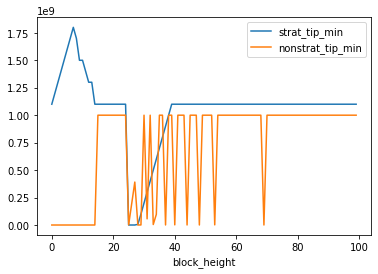

In [14]:
txs_per_group.plot("block_height", ["strat_tip_min", "nonstrat_tip_min"])

<AxesSubplot:xlabel='block_height'>

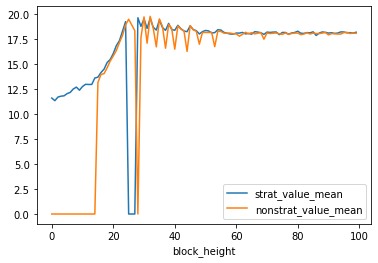

In [15]:
txs_per_group.plot("block_height", ["strat_value_mean", "nonstrat_value_mean"])

<AxesSubplot:xlabel='block_height'>

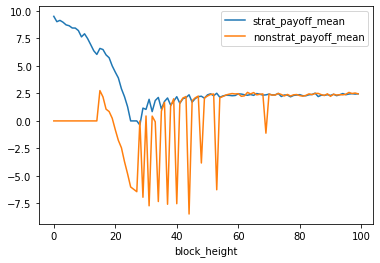

In [16]:
txs_per_group.plot("block_height", ["strat_payoff_mean", "nonstrat_payoff_mean"])

<AxesSubplot:xlabel='block_height'>

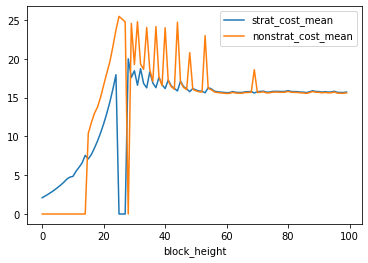

In [17]:
txs_per_group.plot("block_height", ["strat_cost_mean", "nonstrat_cost_mean"])

In [18]:
txs_per_group[(txs_per_group.block_height > 65)][["strat_cost_mean"]].mean()

strat_cost_mean    15.762199
dtype: float64

In [19]:
txs_per_group[(txs_per_group.block_height > 65)][["nonstrat_cost_mean"]].mean()

nonstrat_cost_mean    15.7534
dtype: float64

In [20]:
txs_per_group[(txs_per_group.block_height > 65)][["strat_payoff_mean"]].mean()

strat_payoff_mean    2.371488
dtype: float64

In [21]:
txs_per_group[(txs_per_group.block_height > 65)][["nonstrat_payoff_mean"]].mean()

nonstrat_payoff_mean    2.293301
dtype: float64

In [22]:
txs_per_group[(txs_per_group.block_height > 65)][["strat_value_mean"]].mean()

strat_value_mean    18.133687
dtype: float64

In [23]:
txs_per_group[(txs_per_group.block_height > 65)][["nonstrat_value_mean"]].mean()

nonstrat_value_mean    18.046701
dtype: float64

<AxesSubplot:xlabel='block_height'>

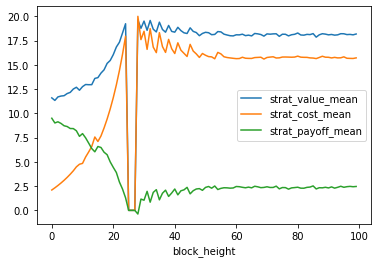

In [24]:
txs_per_group.plot("block_height", ["strat_value_mean", "strat_cost_mean", "strat_payoff_mean"])

<AxesSubplot:xlabel='block_height'>

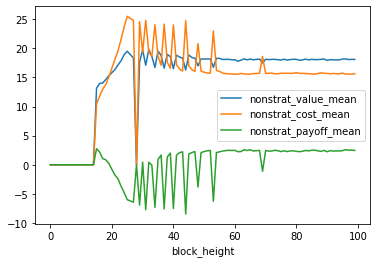

In [35]:
txs_per_group.plot("block_height", ["nonstrat_value_mean", "nonstrat_cost_mean", "nonstrat_payoff_mean"])

## (Bonus) Cancel culture

We now allow users to cancel their transactions. We discussed in the previous notebook's bonus section the concept of _ex post individual rationality_. I might estimate that should my transaction be included within 5 blocks, my payoff will be positive, and so I decide to send it. Fierce competition during transitionary periods however might prevent me from being included when I thought I would be. Without the ability to cancel my transaction, I must stick around in the transaction pool and will net a negative payoff once I am included.

We add here the possibility for users to cancel their transaction. Cancelling is not completely trivial in the current, first-price auction paradigm (see [Etherscan's helpful guide for an overview](https://info.etherscan.com/how-to-cancel-ethereum-pending-transactions/)). To cancel transaction A, the trick is to send another transaction B with the same nonce (your address's "transaction counter") with a slightly higher fee. Miners with access to both A and B in their pool will strictly prefer B and _cannot_ include both.

With EIP 1559, we'll assume users send a new transaction with a slightly higher premium. We also assumed that miners keep around an extensible list of pending transactions, even those rendered invalid from a high basefee, in case the basefee decreases. So we'll assume that as soon as a user sends a replacement transaction to cancel its original transaction, the original transaction disappears from the mempool. The costs to users vary according to the outcome:

- In case the original and replacement transactions have a low gas price such that neither are ever included in a block, the user cancels "for free".
- On the other hand, when the replacement transaction is included, the user incurs a cost. It is rational to cancel whenever the payoff from cancelling the transaction is greater than the payoff from inclusion. Suppose the replacement transaction posts a premium equal to $p'$ (gas price = $g'$), while the original transaction's is $p$ (gas price = $g$). Cancelling yields a payoff of $-g'$, while being included yields $v - w . c - g$, where $v$ is the value, $c$ is the cost for waiting per block and $w$ is the time waited. It is rational to cancel whenever:

$$ v - w . c - g < -g' $$

Of course, $g$ and $g'$ both depend on the current basefee.

In [36]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
            "min_premium": min_premium,
            "cancel_cost": 2 * (10 ** 9), # in wei/gas
        }
        
        #########
        ## ADDED
        ##
        # We ask whether current users want to cancel their transactions waiting in the pool
        cancelled_txs = user_pool.cancel_transactions(txpool, params)
        ##
        # Remove cancelled transactions from the pool
        txpool.remove_txs(cancelled_txs)
        ##
        #########
        
        # We return some demand which on expectation yields 2000 new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # Record the min premium in the block
        min_premium = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "strategic": len([user for user in users if type(user) is StrategicUser]),
            "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "cancelled_txs": len(cancelled_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

In [37]:
blocks = 200
demand_scenario = [2500 for i in range(blocks)]

strategic_share = 0.5
shares_scenario = [{
    StrategicUser: strategic_share,
    OptimisticUser: 1 - strategic_share,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

In [38]:
df

,block,basefee,users,strategic,nonstategic,decided_txs,included_txs,cancelled_txs,blk_min_premium,pool_length
0,0,1.000000,2528,1264,1264,2192,952,0,1.1,1240
1,1,1.124900,2514,1257,1257,2162,952,0,1.2,2450
2,2,1.265400,2466,1233,1233,2073,952,34,1.3,3537
3,3,1.423448,2484,1242,1242,2120,952,78,1.4,4627
4,4,1.601237,2411,1205,1206,2022,952,84,1.5,5613
...,...,...,...,...,...,...,...,...,...,...
195,195,14.613922,2437,1218,1219,488,488,4,1.0,441
196,196,14.659225,2532,1266,1266,492,492,3,1.0,438
197,197,14.720061,2596,1298,1298,531,531,1,1.0,437
198,198,14.931846,2486,1243,1243,430,430,2,1.0,435


<AxesSubplot:xlabel='block'>

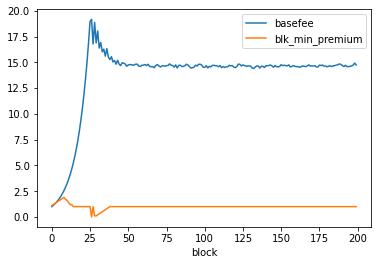

In [39]:
df.plot("block", ["basefee", "blk_min_premium"])

<AxesSubplot:xlabel='block'>

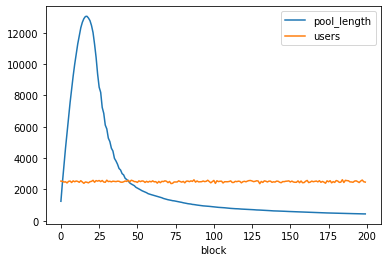

In [40]:
df.plot("block", ["pool_length", "users"])

<AxesSubplot:xlabel='block'>

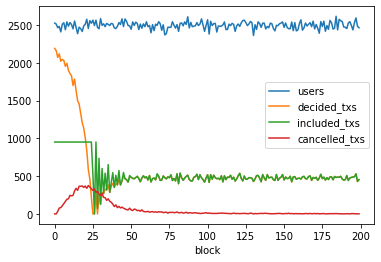

In [41]:
df.plot("block", ["users", "decided_txs", "included_txs", "cancelled_txs"])